In [1]:
import warnings
import os
warnings.filterwarnings('ignore')
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
import tensorflow.keras.backend as K

In [ ]:
#list of samples strings
list_samples = ['train','valid','test']
#dictionary for storing cropped images, image names and labels
arr_dicts = {}

In [ ]:
#importing numpy objects of cropped images
for sampl in list_samples:
    with open(f'./cropped_numpys/cropped_{sampl}_X.npy', 'rb') as f:
        arr_dicts[f'arr_{sampl}_X']  = np.load(f)

arr_train_X = arr_dicts['arr_train_X']
arr_valid_X = arr_dicts['arr_valid_X']
arr_test_X = arr_dicts['arr_test_X']

In [ ]:
#importing numpy objects of image names
for sampl in list_samples:
    with open(f'./cropped_numpys/cropped_{sampl}_X_names.npy', 'rb') as f:
        arr_dicts[f'{sampl}_X_names']  = np.load(f)

train_X_names = arr_dicts['train_X_names']
valid_X_names = arr_dicts['valid_X_names']
test_X_names = arr_dicts['test_X_names']

In [ ]:
#importing numpy objects of labels
for sampl in list_samples:
    with open(f'./cropped_numpys/cropped_{sampl}_Y.npy', 'rb') as f:
        arr_dicts[f'arr_{sampl}_Y']  = np.load(f)

arr_train_Y = arr_dicts['arr_train_Y']
arr_valid_Y = arr_dicts['arr_valid_Y']
arr_test_Y = arr_dicts['arr_test_Y']

In [ ]:
#function for creation of triplets
def	make_triplets(images, labels, image_names):

	tripletImages = []
	tripletImagesNames = []
	uniqueClasses = np.unique(labels)

	dict_idx = {i:np.where(labels == i)[0] for i in uniqueClasses}

	for idxA in range(len(images)):

		#current image
		currentImage = images[idxA]
		label = labels[idxA]
		currentImage_name = image_names[idxA]

		#positive image
		idxB = np.random.choice(dict_idx[label])
		posImage = images[idxB]
		posImage_name = image_names[idxB]

		#negative image
		negLab = np.random.choice([i for i in dict_idx.keys() if i != label])
		negIdx = np.random.choice(dict_idx[negLab])
		negImage = images[negIdx]
		negImage_name = image_names[negIdx]
        
		#saving the triplets of images and image names
		tripletImages.append([currentImage, posImage, negImage])
		tripletImagesNames.append([currentImage_name, posImage_name, negImage_name])

	return (np.array(tripletImages), np.array(tripletImagesNames))

In [ ]:
train_X_triplets, train_triplets_names= make_triplets(arr_train_X, arr_train_Y, train_X_names)
valid_X_triplets, valid_triplets_names = make_triplets(arr_valid_X, arr_valid_Y, valid_X_names)
test_X_triplets, test_triplets_names = make_triplets(arr_test_X, arr_test_Y, test_X_names)

In [ ]:
if not os.path.exists('./triplet_numpys/'):
    os.makedirs('./triplet_numpys/')

In [ ]:
dict_triplets = {'train': {'triplet_imgs': train_X_triplets, 'triplet_imgs_names':train_triplets_names},
                'valid': {'triplet_imgs': valid_X_triplets,'triplet_imgs_names':valid_triplets_names},
                'test': {'triplet_imgs': test_X_triplets, 'triplet_imgs_names':test_triplets_names}}

In [ ]:
print('Number of training triplets:',len(train_X_triplets))
print('Number of validation triplets:',len(valid_X_triplets))
print('Number of test triplets:',len(test_X_triplets))

Number of training triplets: 6000
Number of validation triplets: 2000
Number of test triplets: 2000


In [ ]:
#exporting the triplets of images and image names as numpy objects.
for sampl in dict_triplets.keys():
    for n in dict_triplets[sampl].keys():
       with open(f'./triplet_numpys/{sampl}_{n}.npy', 'wb') as f:
            np.save(f, dict_triplets[sampl][n])

NN model building with triplet loss

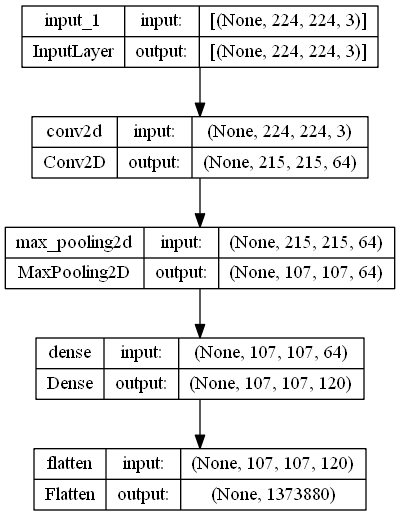

In [ ]:
def initialize_base_network():
    input = Input(shape=(224,224,3))

    x = Conv2D(64, (10,10), activation='relu')(input)
    x = MaxPooling2D(2, 2)(x)
    x = Dense(120, activation='relu')(x)
    x = Flatten()(x)

    return Model(inputs=input, outputs=x)

embedding = initialize_base_network()
tf.keras.utils.plot_model(embedding, show_shapes=True)

In [ ]:
class SiameseNet(tf.keras.layers.Layer):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, feat):
        feats = self.model(feat[0])
        pfeats = self.model(feat[1])
        nfeats = self.model(feat[2])
        result = tf.stack([feats, pfeats, nfeats])
        return result

class TripletLoss(tf.keras.layers.Layer):
    def __init__(self, margin):
        self.margin = margin
        super().__init__()
        
    def distance(self, x, y):
        sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
        return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

    def call(self, features):
        pos = self.distance(features[0], features[1])
        neg = self.distance(features[0], features[2])
        loss = pos - neg
        return tf.maximum(loss + self.margin, 0.0)

In [ ]:
image_input = Input(shape=(224,224,3), name='image_input')
positive_input = Input(shape=(224,224,3), name='positive_input')
negative_input = Input(shape=(224,224,3), name='negative_input')

In [ ]:
def identity_loss(y_true, y_pred):
    return tf.reduce_mean(abs(y_true - y_pred))

In [ ]:
siamese = SiameseNet(embedding)([image_input, positive_input, negative_input])
loss = TripletLoss(margin=1.0)(siamese)
model = Model(inputs=[image_input, positive_input, negative_input], outputs=loss)
model.compile(optimizer ='adam', loss = identity_loss)

In [ ]:
history = model.fit([train_X_triplets[:,0], train_X_triplets[:,1], train_X_triplets[:,2]], np.ones(train_X_triplets.shape[0]),
                verbose=1,
            validation_data=([valid_X_triplets[:,0], valid_X_triplets[:,1], valid_X_triplets[:,2]], np.ones(valid_X_triplets.shape[0])),
            epochs=5)

Predictions

In [ ]:
#function creating pairs
def	make_pairs(images, labels):

	pairImages = []
	pairLabels = []
	uniqueClasses = np.unique(labels)

	dict_idx = {i:np.where(labels == i)[0] for i in uniqueClasses}

	for idxA in range(len(images)):
		currentImage = images[idxA]
		label = labels[idxA]

		#positive pair
		idxB = np.random.choice(dict_idx[label])
		posImage = images[idxB]
		pairImages.append([currentImage, posImage])

		pairLabels.append([1])

		#negative pair
		negLab = np.random.choice([i for i in dict_idx.keys() if i != label])
		negIdx = np.random.choice(dict_idx[negLab])
		negImage = images[negIdx]s
		pairImages.append([currentImage, negImage])

		pairLabels.append([0])

	return (np.array(pairImages),np.array(pairLabels))

In [ ]:
pairTest, labelTest = make_pairs(arr_test_X, arr_test_Y)

In [ ]:
left_pair = pairTest[:,0]
right_pair = pairTest[:,1]

In [ ]:
left_pair_pred = embedding.predict(left_pair)
right_pair_pred = embedding.predict(right_pair)

125/125 [==============================] - 2s 18ms/step


In [ ]:
def compute_accuracy(left_pred, right_pred, y_true):
    y_pred = np.linalg.norm(left_pred - right_pred, axis=1)
#     # 1 for the same - distance is smaller than 3.0, 0 for the different
    pred = y_pred < 7.0
    return np.mean(pred == y_true)

In [ ]:
test_accuracy = compute_accuracy(left_pair_pred, right_pair_pred, labelTest)
print(f'Test accuracy: {test_accuracy*100:.2f}%')

Test accuracy: 50.00%
